# Figure 3: Benchmarks

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from datetime import datetime
from os import path
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.tasks.sir import SIR
from loss_cal.tasks.lotka_volterra import LotkaVolterra
from loss_cal.tasks.linear_gaussian import LinGauss

plot_config_file = "loss_cal/utils/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

color_npe = "#377eb8"
color_nn = "#ff7f00"
color_post = "#4daf4a"
save_dir = "./paper/fig3/"

Benchmark Tasks: SIR, LV, LinGauss

In [3]:
now = datetime.now().strftime("%Y-%d-%m-%H_%M")

In [4]:
bm_tasks = {
    "toy_example": ToyExample(action_type="continuous"),
    "linear_gaussian": LinGauss(action_type="continuous"),
    "sir": SIR(action_type="continuous"),
    "lotka_volterra": LotkaVolterra(action_type="continuous"),
}
bm_task_params = {
    "toy_example":0,
    "sir": None,
    "lotka_volterra": [0,1,2,3],
    "linear_gaussian": None,
}

### Difference Incurred Costs

In [5]:
test_nsim = [500, 1_000, 5_000, 10_000, 50_000, 100_000]
seeds = [0, 54, 943]
num_npe_samples = [10, 100, 1000, 10000]
num_action_samples = "inloop"

In [ ]:
fig, axes = plt.subplots(1, 7, figsize=(9.7, 1.5), sharey=True, sharex=True)

axes[0].set_ylabel("diff. incurred cost")
axes[0].set_xscale("log")
axes[0].set_xticks([1000, 10000, 100000])
axes[0].get_xaxis().set_tick_params(which="minor", size=0)
axes[0].set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
axes[3].set_xlabel("# simulations")

i = 0
s = num_npe_samples.index(1000)

with mpl.rc_context(fname=plot_config_file):
    for bm_task in list(bm_tasks.keys()):
        task = bm_tasks[bm_task]
        task_name = task.task_name
        param = bm_task_params[bm_task]
        base_dir = f"./results/{bm_task}/continuous/fig_diff_costs/"
        for p, pname in (
            [(param, None)]
            if task_name != "lotka_volterra"
            else enumerate(task.parameter_names)
        ):
            print(task_name, p)
            axes[i].set_title(
                task.display_name
                if task_name != "lotka_volterra"
                else task.display_name + f" {pname}"
            )

            # Load Costs and average over seeds
            posterior_costs = torch.stack(
                [
                    torch.load(
                        path.join(base_dir, f"{seed}/param{p}_posterior_costs.pt")
                    )
                    for seed in seeds
                ]
            ).mean(dim=0)

            nn_costs = torch.stack(
                [
                    torch.load(
                        path.join(
                            base_dir,
                            f"{seed}/{num_action_samples}/param{p}_nn_costs.pt",
                        )
                    )
                    for seed in seeds
                ]
            ).mean(dim=0)

        
            npe_costs = torch.stack(
                [
                    torch.load(path.join(base_dir, f"{seed}/param{p}_npe_costs.pt"))
                    for seed in seeds
                ]
            ).mean(dim=0)

            # Axis and label settings
            axes[i].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            axes[i].get_xaxis().set_tick_params(which="minor", size=0)
            axes[i].set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
            axes[i].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            axes[i].get_yaxis().set_tick_params(which="minor", size=0)

            # Plot incurred costs
            # for s in range(npe_costs.shape[-1]):
            
            axes[i].plot(
                test_nsim,
                (npe_costs[:, :, s] - posterior_costs).mean(dim=1),
                c=color_npe,
                # alpha=(s + 1) / (npe_costs.shape[-1] + 1),
                label=f"NPE-MC",  # ({num_npe_samples[s]} post. samples)",
            )

            axes[i].plot(
                test_nsim,
                (nn_costs - posterior_costs).mean(dim=1),
                c=color_nn,
                label="BAM",
            )
            print("nn_costs", nn_costs.mean(dim=1))
            print("npe_costs", npe_costs[:, :, s].mean(dim=1))

            # scatter data points on top
            # for s in range(npe_costs.shape[-1]):
            
            axes[i].scatter(
                test_nsim,
                (npe_costs[:, :, s] - posterior_costs).mean(dim=1),
                c=color_npe,
                # alpha=(s + 1) / (npe_costs.shape[-1] + 1),
            )

            axes[i].scatter(
                test_nsim,
                (nn_costs - posterior_costs).mean(dim=1),
                c=color_nn,
            )

            i = i + 1
axes[-1].legend(
    loc="lower left", bbox_to_anchor=(1, 0.5), handlelength=0.95, handletextpad=0.5
)
# axes[3].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.7))
plt.savefig(f"./paper/fig3/fig3.svg")
plt.show()

### Figure: Incurred Costs over num_action_samples

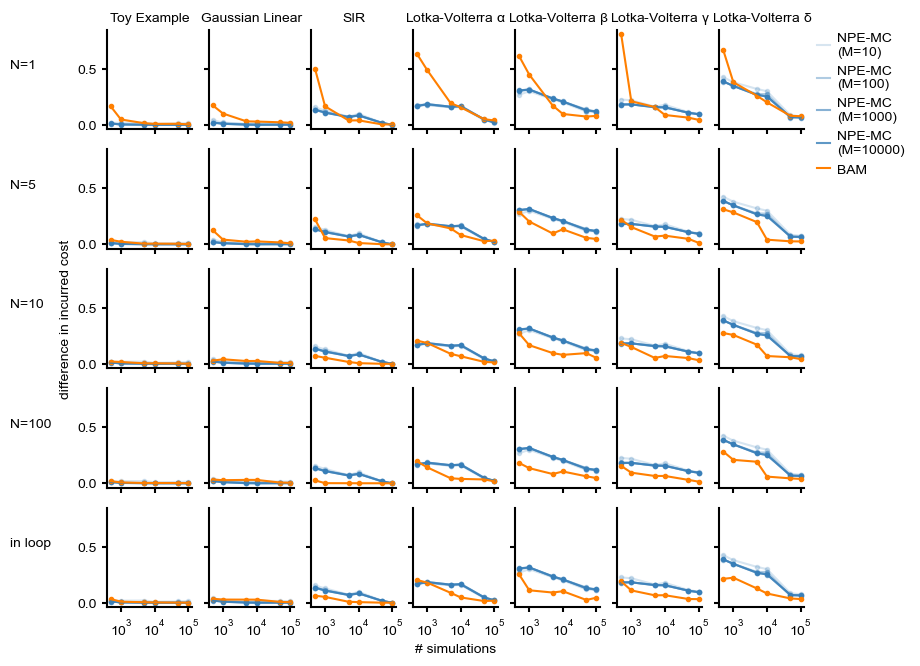

In [7]:
test_nsim = [500, 1_000, 5_000, 10_000, 50_000, 100_000]
seeds = [0, 54, 943]
num_npe_samples = [10, 100, 1000, 10000]
num_action_samples = [f"{i}actions" for i in [1, 5, 10, 100]] + ["inloop"]  # "5actions"
num_action_labels  = [f"N={i}" for i in [1, 5, 10, 100]] + ["in loop"]
seed = 0


fig, axes = plt.subplots(
    len(num_action_samples), 7, figsize=(9, 7.5), sharey=True, sharex=True
)

# axes[0,0].set_yscale("log")
# axes[0].set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5])

axes[0, 0].set_xscale("log")
axes[0, 0].set_xticks(
    [1000, 10000, 100000]
)  # , labels=[r"$10^3$", r"$10^4$", r"$10^5$"], rotation=90)
axes[0, 0].get_xaxis().set_tick_params(which="minor", size=0)
axes[0, 0].set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
axes[len(num_action_samples) - 1, 3].set_xlabel("# simulations")
axes[2, 0].set_ylabel("difference in incurred cost")  
# axes[len(num_action_samples) - 1, 0].set_ylabel("diff. incurred cost")


with mpl.rc_context(fname=plot_config_file):
    for ni, n in enumerate(num_action_samples):
        # axes[ni, 0].set_suptitle(f'Subfigure title {n}')
        axes[ni, 0].text(0.5, 0.5, num_action_labels[ni])
        # axes[ni,0].set_ylim(-0.01,0.5)
        i = 0
        s = num_npe_samples.index(1000)
        for bm_task in list(bm_tasks.keys()):
            task = bm_tasks[bm_task]
            task_name = task.task_name
            param = bm_task_params[bm_task]
            base_dir = f"./results/{bm_task}/continuous/fig_diff_costs/"
            for p, pname in (
                [(param, None)] if task_name != "lotka_volterra" else enumerate(task.parameter_names)
            ):
                if ni == 0:
                    axes[ni, i].set_title(
                        task.display_name
                        if task_name != "lotka_volterra"
                        else task.display_name + f" {pname}"
                    )

                # Load Costs and average over seeds
                posterior_costs = torch.stack(
                    [
                        torch.load(path.join(base_dir, f"{seed}/param{p}_posterior_costs.pt"))
                        for seed in seeds
                    ]
                ).mean(dim=0)
                nn_costs = torch.stack(
                    [
                        torch.load(path.join(base_dir, f"{seed}/{n}/param{p}_nn_costs.pt"))
                        for seed in seeds
                    ]
                ).mean(dim=0)

                npe_costs = torch.stack(
                    [
                        torch.load(path.join(base_dir, f"{seed}/param{p}_npe_costs.pt"))
                        for seed in seeds
                    ]
                ).mean(dim=0)

                # Axis and label settings
                axes[ni, i].get_xaxis().set_major_formatter(
                    mpl.ticker.ScalarFormatter()
                )
                axes[ni, i].get_xaxis().set_tick_params(which="minor", size=0)
                axes[ni, i].set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
                axes[ni, i].get_yaxis().set_major_formatter(
                    mpl.ticker.ScalarFormatter()
                )
                axes[ni, i].get_yaxis().set_tick_params(which="minor", size=0)

                # Plot incurred costs
                for s in range(npe_costs.shape[-1]):
                    axes[ni, i].plot(
                        test_nsim,
                        (npe_costs[:, :, s] - posterior_costs).mean(dim=1),
                        c=color_npe,
                        alpha=(s + 1) / (npe_costs.shape[-1] + 1),
                        label=f"NPE-MC\n(M={num_npe_samples[s]})", # ({num_npe_samples[s]} post. samples)",
                    )

                axes[ni, i].plot(
                    test_nsim,
                    (nn_costs - posterior_costs).mean(dim=1),
                    c=color_nn,
                    label="BAM",
                )

                # scatter data points on top
                for s in range(npe_costs.shape[-1]):
                    axes[ni, i].scatter(
                        test_nsim,
                        (npe_costs[:, :, s] - posterior_costs).mean(dim=1),
                        c=color_npe,
                        alpha=(s + 1) / (npe_costs.shape[-1] + 1),
                    )

                axes[ni, i].scatter(
                    test_nsim,
                    (nn_costs - posterior_costs).mean(dim=1),
                    c=color_nn,
                )

                i = i + 1
axes[0,6].legend(loc="upper left", bbox_to_anchor=(1.0, 1.1), handlelength=0.95, handletextpad=0.5) 
plt.savefig("./paper/fig3/fig3allvariants.svg")
plt.show()

diff in incurred costs = deviation from ground truth (posterior would be at 0)

### Combine figures to one multipanel figure

In [8]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("21.59cm", "5.0cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig3/fig3.svg").scale(svg_scale),
          #Text("a", 20., 2.0, **kwargs_text),
    ).move(0, 10),
)

f

In [9]:
# !mkdir -p fig
f.save("./paper/fig3/fig3.svg")
# svg("./paper/fig2/fig2.png")

In [10]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

fall = Figure("21.59cm", "16cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig3/fig3allvariants.svg").scale(svg_scale),
          #Text("a", 20., 2.0, **kwargs_text),
    ).move(0, 10),
)

fall

In [11]:
fall.save("./paper/fig3/fig3allvariants.svg")